# EDA

In [6]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from scipy.stats import norm, skew

from scipy.special import boxcox1p, inv_boxcox1p

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [3]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.2
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

<AxesSubplot:xlabel='edad', ylabel='Density'>

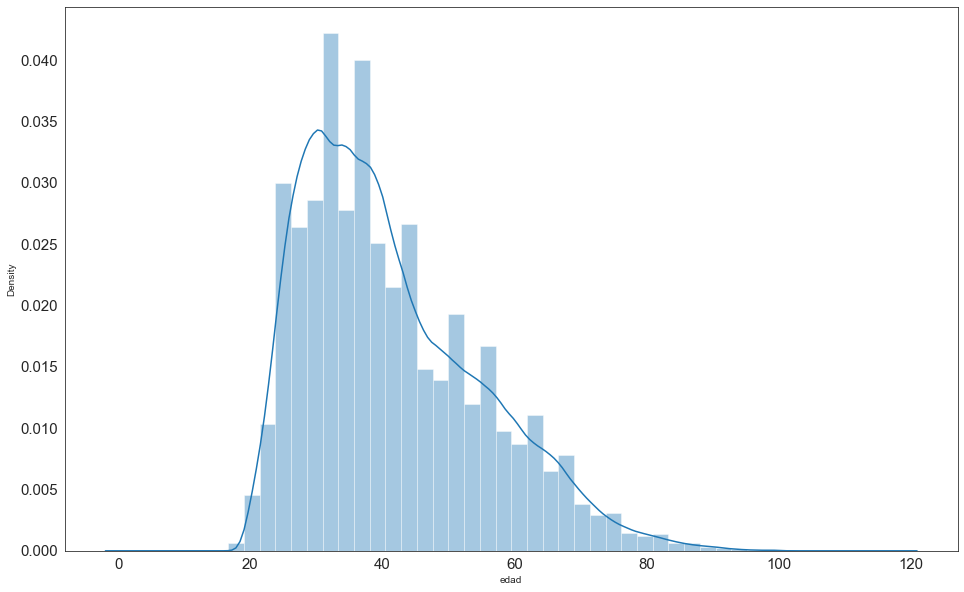

In [16]:
sns.distplot(bc_dataframe['edad'])

In [17]:
bc_dataframe['cupo_total_tc'].describe()

count     4197938.00000
mean      4428787.03945
std      10936162.05056
min             0.00000
25%             0.00000
50%             0.00000
75%       4700000.00000
max     966200000.00000
Name: cupo_total_tc, dtype: float64

<AxesSubplot:xlabel='cupo_total_tc', ylabel='Density'>

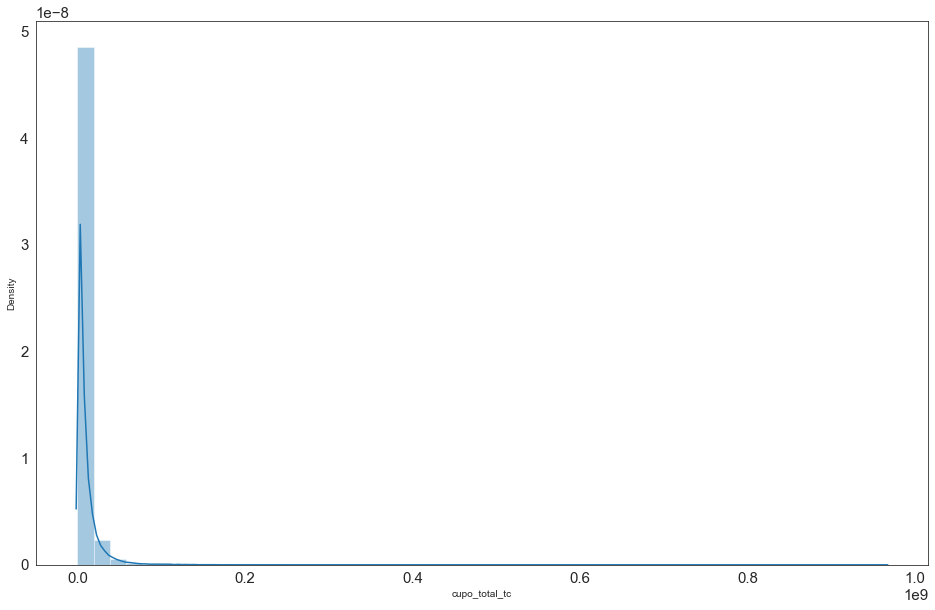

In [18]:
sns.distplot(bc_dataframe['cupo_total_tc'])

In [100]:
print(np.quantile(bc_dataframe['cant_oblig_tot_sf'], 0.99))
bc_dataframe['cant_oblig_tot_sf'].describe()

15.0


count   4197938.00000
mean          2.76423
std           3.41020
min           0.00000
25%           0.00000
50%           2.00000
75%           4.00000
max         152.00000
Name: cant_oblig_tot_sf, dtype: float64

In [90]:
pd.set_option('display.max_columns', 100)

In [91]:
bc_dataframe.describe()

,periodo,id_cli,edad,ult_actual,cupo_total_tc,tenencia_tc,cuota_tc_bancolombia,tiene_consumo,tiene_crediagil,nro_tot_cuentas,ctas_activas,tiene_ctas_activas,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,ingreso_final,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,ingreso_nomina,ingreso_segurida_social,gasto_familiar
count,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4167174.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4197938.00000,4196567.00000,4197938.00000,4197938.00000,4197938.00000
mean,201959.34743,3355713.67896,41.37425,20190312.44544,4428787.03945,0.38562,195162.55094,0.12732,0.13695,1.07778,1.02052,0.00000,66713.35146,1066139.10020,154843.76401,1220982.86421,4948032.06672,161075.73437,635647.49771,28823.15651,387569.26710,55382.12332,342635.67137,7301951.32015,2082388.74590,440039.89697,20040415.98852,75470.93097,2.76423,1260308.76634,768089.24572,839397.96100,858685.49484
std,49.68804,2472095.11067,13.58533,54483.15930,10936162.05056,0.48674,613688.41008,0.33333,0.34379,0.43988,0.40696,0.00000,339930.39165,2518869.73168,883753.37062,2624821.73292,13345164.26283,972901.73723,4994670.37609,1128095.07636,2437051.15004,2707838.35354,30798742.82564,30244833.97556,24443151.32547,5259767.58953,84708725.75541,1080090.32454,3.41020,34346211.30390,1934478.06511,2328229.91894,2486611.07363
min,201902.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-21225012.72428,0.00000,0.00000,0.00000,0.00000,-21225012.72428,-314870000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-49942386763.75000,0.00000,0.00000,-115561000.00000
25%,201907.00000,1337804.25000,31.00000,20190109.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1600000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,160575.00000,0.00000,0.00000,181950.00000
50%,202001.00000,2825507.50000,38.00000,20190718.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2734086.50000,0.00000,0.00000,0.00000,60000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,124000.00000,0.00000,2.00000,750997.75000,0.00000,0.00000,431850.99500
75%,202007.00000,4877898.00000,50.00000,20200102.00000,4700000.00000,1.00000,197200.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1488984.00000,0.00000,1749162.75000,5011374.75000,0.00000,480000.00000,0.00000,404000.00000,0.00000,0.00000,6660000.00000,1228500.00000,181000.00000,13489000.00000,0.00000,4.00000,2008500.00000,858900.00000,828116.00000,929775.75000
max,202011.00000,8704800.00000,119.00000,20201020.00000,966200000.00000,1.00000,121985131.10400,1.00000,1.00000,35.00000,35.00000,0.00000,38550828.18000,465000000.00000,524059655.00000,524059655.00000,4012032558.50000,572309000.00000,2460707000.00000,1008301000.00000,4396925000.00000,2051625000.00000,49950000000.00000,50021554000.00000,39003242000.00000,9770945000.00000,46611782000.00000,198645000.00000,152.00000,555111381.74500,163272195.50000,447000000.00000,1083040050.35000


In [26]:
bc_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4197938 entries, 0 to 220805
Data columns (total 48 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   periodo                        int64  
 1   id_cli                         int64  
 2   edad                           int64  
 3   genero                         object 
 4   estado_civil                   object 
 5   nivel_academico                object 
 6   ocupacion                      object 
 7   tipo_vivienda                  object 
 8   ult_actual                     int64  
 9   categoria                      object 
 10  ind_mora_vigente               object 
 11  departamento_residencia        object 
 12  mora_max                       object 
 13  cupo_total_tc                  float64
 14  tenencia_tc                    int64  
 15  cuota_tc_bancolombia           float64
 16  tiene_consumo                  int64  
 17  tiene_crediagil                int64  
 18  nro

In [113]:
bc_dataframe['ind_sin_gasto'] = bc_dataframe['ingreso_final'] -  bc_dataframe[[ 'cuota_de_vivienda', 'cuota_de_consumo', 'cuota_rotativos' , 
              'cuota_sector_real_comercio', 'cuota_tarjeta_de_credito', 'cuota_de_sector_solidario',
              'cuota_sector_real_comercio', 'cuota_libranza_sf']].sum(axis=1)
bc_dataframe[['ind_sin_gasto', 'gasto_familiar']].corr()

,ind_sin_gasto,gasto_familiar
ind_sin_gasto,1.00000,0.03246
gasto_familiar,0.03246,1.00000


In [115]:
bc_dataframe[[ 'cuota_de_vivienda', 'cuota_de_consumo', 'cuota_rotativos' , 
              'cuota_sector_real_comercio', 'cuota_tarjeta_de_credito', 'cuota_de_sector_solidario',
              'cuota_sector_real_comercio', 'cuota_libranza_sf']].sum(axis=1)

0         275000.00000
1              0.00000
2        2271000.00000
3        7754000.00000
4              0.00000
              ...     
220801   2304000.00000
220802         0.00000
220803   2574841.95000
220804         0.00000
220805    486000.00000
Length: 4197938, dtype: float64

In [116]:
bc_dataframe['ocupacion'].value_counts()

Empleado                     2576646
Independiente                 457612
Estudiante                    267000
Profesional Independiente     211789
Jubilado                      202657
Comerciante                   106078
Socio Empleado - Socio        100900
Ama de Casa                    89847
Otro                           54376
Rentista de Capital            39830
Pensionado                     39205
Sin Ocupacion Asignada         11731
Desempleado sin Ingresos       11580
Desempleado con Ingresos       11129
Ganadero                        9500
Agricultor                      6068
\N                              1935
Vacío                             55
Name: ocupacion, dtype: int64

In [118]:
filtered_dataframe = bc_dataframe[
            #(dataframe['edad'] < 100) & # Imputar a percentil 99
            (bc_dataframe['gasto_familiar'] > 40000) &
            #(dataframe['edad'] >=20) &
            (bc_dataframe['gasto_familiar'] < 30000000) &
            # (dataframe['cant_oblig_tot_sf'] < 13) &
            (bc_dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
            (bc_dataframe['ingreso_final'] < 50000000) &
            (bc_dataframe['cuota_cred_hipot'] >= 0) &
            (bc_dataframe['cupo_total_tc'] < 50000000) & # Percentil 99%
            (bc_dataframe['cuota_tc_bancolombia'] < 10000000) & # percentil 99.99%
            (bc_dataframe['cuota_de_vivienda'] < 10000000) &# Percentil 99.99%
            (bc_dataframe['cuota_de_consumo'] < 10000000) & # percentil 99%
            (bc_dataframe['cuota_rotativos'] < 10000000)& # percentil 99.99%
            (bc_dataframe['cuota_tarjeta_de_credito'] < 10000000) & 
            (bc_dataframe['cuota_de_sector_solidario'] < 10000000) &
            (bc_dataframe['cuota_sector_real_comercio'] < 13000000) &# Percentil 99.5%
            (bc_dataframe['cuota_libranza_sf'] < 5000000) & # Percentil 99
            (bc_dataframe['ingreso_segurida_social'] < 25000000) & # percentil 99.9
            (bc_dataframe['ingreso_nomina'] < 20000000) &
            (bc_dataframe['saldo_prom3_tdc_mdo'] < 30000000) &
            (bc_dataframe['saldo_no_rot_mdo'] < 300000000) &
            (bc_dataframe['cuota_cred_hipot'] < 10000000) &
            (bc_dataframe['mediana_nom3'] < 20000000) &
            (bc_dataframe['mediana_pen3'] < 11000000) &
            (bc_dataframe['cuota_tc_mdo'] < 30000000) &
            (bc_dataframe['ingreso_nompen'] < 3000000) &
            (bc_dataframe['cant_oblig_tot_sf'] <= 15) &
            (bc_dataframe['ctas_activas'] < 5) &
            (bc_dataframe['nro_tot_cuentas'] < 5) 
          #  ~(dataframe['departamento_residencia'].isin(['MADRID', 'ESTADO DE LA FLORIDA', 'VAUPES']))
        ] 
filtered_dataframe

,periodo,id_cli,edad,genero,estado_civil,nivel_academico,ocupacion,tipo_vivienda,ult_actual,categoria,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,tenencia_tc,cuota_tc_bancolombia,tiene_consumo,tiene_crediagil,nro_tot_cuentas,ctas_activas,tiene_ctas_activas,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,cat_ingreso,ingreso_final,cant_mora_30_tdc_ult_3m_sf,cant_mora_30_consum_ult_3m_sf,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar,ind_sin_gasto
0,201902,2089776,35,M,DIV,TECNOLOGO,Empleado,ALQUILADA,20180526,1,N,VALLE,NApl,0.00000,0,0.00000,0,0,1,1,0,0.00000,1172612.00000,0.00000,1172612.00000,NOM,1172612.00000,SIN MORA,SIN MORA,0.00000,275000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2433000.00000,0.00000,1,311306.00000,C,cumple,N,1172612.00000,0.00000,170490.00000,897612.00000
1,201902,2088089,32,M,UL,NO INFORMA,Independiente,FAMILIAR,20181120,4,N,VALLE,NApl,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,2327500.00000,NApl,NApl,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,1187025.00000,NApl,incumple,N,0.00000,0.00000,187990.00000,2327500.00000
3,201902,2892385,33,M,SOL,ESPECIALIZACION,Otro,FAMILIAR,20181106,2,N,HUILA,Entre 0 y 30 dias,6650000.00000,1,461176.58250,1,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,11325895.00000,CON MORA,CON MORA,0.00000,2934000.00000,0.00000,4244000.00000,0.00000,288000.00000,20967000.00000,3171000.00000,8055000.00000,21225000.00000,0.00000,7,-727092.47500,H,NApl,N,0.00000,0.00000,562109.74000,3571895.00000
4,201902,1259581,57,F,CAS,BACHILLER,Comerciante,PROPIA,20180808,4,N,ANTIOQUIA,NApl,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,4310000.00000,NApl,NApl,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,2564450.00000,NApl,incumple,N,0.00000,0.00000,436494.00000,4310000.00000
5,201902,2892417,30,F,NI,UNIVERSITARIO,Empleado,\N,20180826,1,N,BOGOTA D.C.,Entre 0 y 30 dias,0.00000,0,0.00000,1,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,5113332.00000,SIN MORA,SIN MORA,0.00000,1347000.00000,0.00000,255000.00000,789000.00000,69000.00000,5648000.00000,1569500.00000,567000.00000,48487000.00000,689000.00000,7,1808332.40000,C,cumple,N,0.00000,0.00000,1221597.00000,1895332.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220801,202011,2080694,37,F,SOL,ESPECIALIZACION,Empleado,FAMILIAR,20191224,1,S,CALDAS,Entre 0 y 30 dias,3800000.00000,1,220400.00000,0,0,1,1,0,0.00000,2237290.00000,0.00000,2237290.00000,NOM,3323450.00000,SIN MORA,SIN MORA,0.00000,0.00000,0.00000,0.00000,0.00000,1152000.00000,0.00000,0.00000,0.00000,31668000.00000,0.00000,1,696447.62500,E,NApl,N,2538236.00000,3323450.00000,210949.98000,1019450.00000
220802,202011,3518141,34,M,UL,TECNOLOGO,Independiente,\N,20200623,1,N,ANTIOQUIA,NApl,0.00000,0,0.00000,0,0,2,2,0,0.00000,0.00000,0.00000,0.00000,OTROS,1307593.00000,NApl,NApl,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,555727.02500,E,incumple,N,0.00000,0.00000,318468.00000,1307593.00000
220803,202011,2085132,41,M,UL,TECNOLOGO,Empleado,ALQUILADA,20200908,1,N,RISARALDA,Entre 0 y 30 dias,2600000.00000,1,150800.00000,1,1,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,4079000.00000,SIN MORA,SIN MORA,0.00000,1417841.95000,0.00000,563000.00000,0.00000,297000.00000,10500000.00000,8901000.00000,0.00000,30327000.00000,0.00000,13,149163.05000,F,cumple,N,0.00000,828116.00000,1666454.00000,1504158.05000
220804,202011,2886634,61,F,NI,UNIVERSITARIO,Empleado,FAMILIAR,

<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

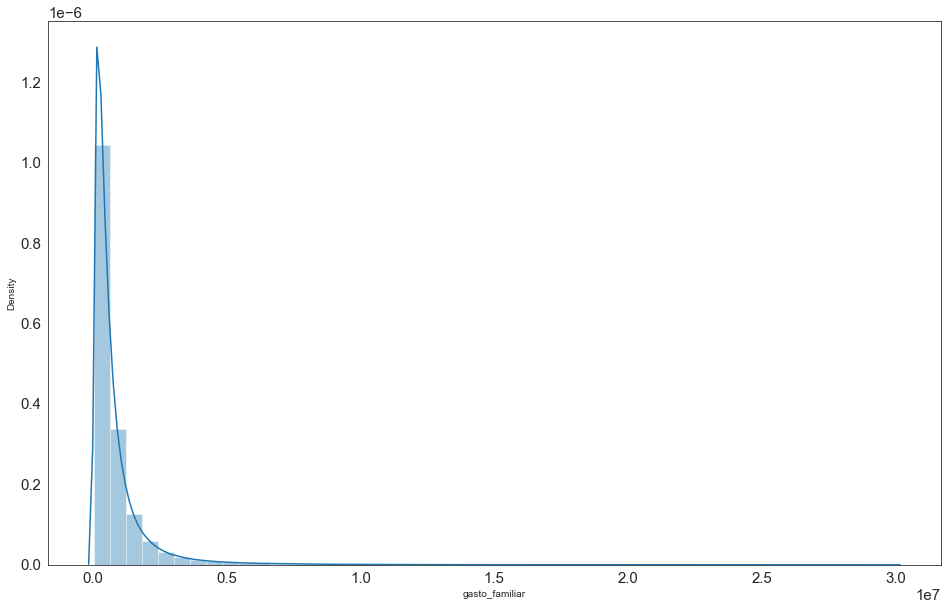

In [120]:
sns.distplot(filtered_dataframe['gasto_familiar'])

<AxesSubplot:xlabel='cuota_de_consumo', ylabel='Density'>

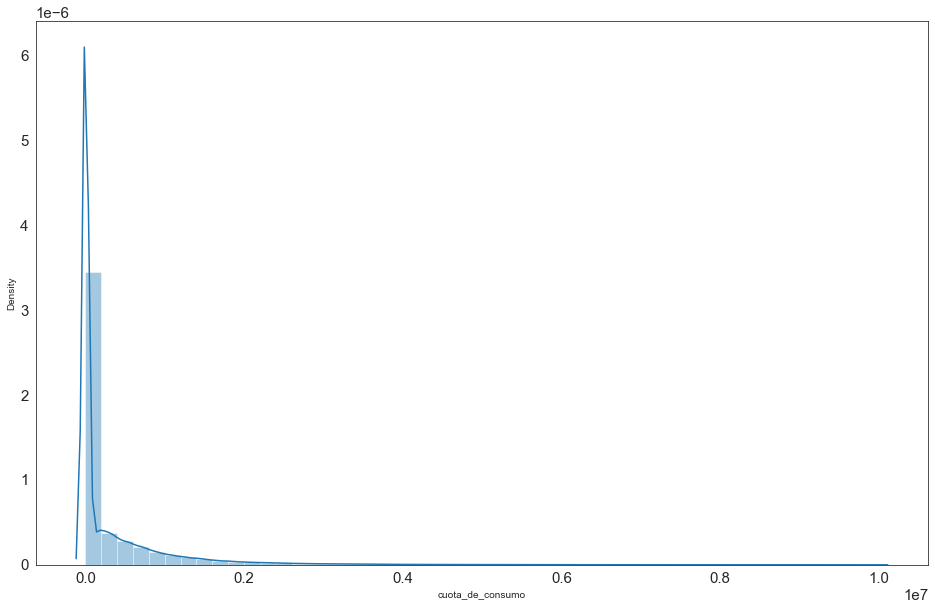

In [121]:
sns.distplot(filtered_dataframe['cuota_de_consumo'])